In [ ]:
!pip install pytorch-lightning datasets segmentation_models_pytorch fpsample

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.0/332.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/cis-680-team/cis680-team

import finetune_v2 as v2
import finetune_v3 as v3

from datasets import load_dataset
import torch
import torch.nn.functional as F
import ncut_pytorch.backbone
from ncut_pytorch import NCUT, rgb_from_tsne_3d
from ncut_pytorch.backbone import load_model, extract_features
import numpy as np
from PIL import Image
from types import SimpleNamespace
import segment_anything as sa
import matplotlib.pyplot as plt

import sys
sys.path.append('Full_Segment_Anything')
from build_sam import sam_model_registry


Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1uetsGLzYUKFWfjNan9S9dahWTlFEDwPX/cis-680-team/cis680-team
0 1 cuda
0 1 cuda


In [ ]:

layer, batch_size = 11, 4

In [ ]:
def transform_image(image, resolution=(1024, 1024)):
    image = image.convert('RGB').resize(resolution, Image.LANCZOS)
    # Convert to torch tensor
    image = torch.tensor(np.array(image).transpose(2, 0, 1)).float()
    image = image / 255
    # Normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - torch.tensor(mean).view(3, 1, 1)) / torch.tensor(std).view(3, 1, 1)
    return image

def resize_tensor(tensor, new_size):
    """
    Resizes a [C, H, W] tensor to [C, new_H, new_W].

    Args:
        tensor (torch.Tensor): The input tensor of shape [C, H, W].
        new_size (tuple): The desired output size as (height, width).

    Returns:
        torch.Tensor: The resized tensor of shape [C, new_H, new_W].
    """
    # Add batch dimension: [1, C, H, W]
    tensor_batch = tensor.unsqueeze(0)

    # Perform interpolation
    resized_batch = F.interpolate(tensor_batch, size=new_size, mode='bilinear', align_corners=False)

    # Remove batch dimension: [C, new_H, new_W]
    resized_tensor = resized_batch.squeeze(0)

    return resized_tensor

In [ ]:
dataset_inference = load_dataset('EgoThink/EgoThink', 'Activity', trust_remote_code=True)
dataset_inference = dataset_inference['test']
images = [dataset_inference[i]['image'] for i in range(50)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/132M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# for 256
images_tsf1 = torch.stack([transform_image(img, resolution=(256, 256)) for img in images])
# for 1024
images_tsf2 = torch.stack([transform_image(img, resolution=(1024, 1024)) for img in images])
# for 1024 -> 256 -> 1024
images_tsf3 = torch.stack([resize_tensor(transform_image(img, resolution=(256, 256)), (1024, 1024)) for img in images])


KeyboardInterrupt: 

## Modified SAM Architecture for 256 versus Original SAM

In [ ]:
# for 1024 and 1024 -> 256 -> 1024
original_sam = sa.sam_model_registry['vit_b'](checkpoint="sam_vit_b_01ec64.pth")
original_sam.eval()
print()

/content/drive/.shortcut-targets-by-id/1uetsGLzYUKFWfjNan9S9dahWTlFEDwPX/cis-680-team/cis680-team/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

In [ ]:
# for 256
modified_sam = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth', custom_img_size=256).cuda()


/content/drive/.shortcut-targets-by-id/1uetsGLzYUKFWfjNan9S9dahWTlFEDwPX/cis-680-team/cis680-team/./Full_Segment_Anything/build_sam.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

In [ ]:
# for 256
ncut_model1 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=modified_sam, img_size=256)
model_features1 = extract_features(images_tsf1, ncut_model1, node_type='attn', layer=layer, batch_size=batch_size)

# for 1024
ncut_model2 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=original_sam, img_size=1024)
model_features2 = extract_features(images_tsf2, ncut_model2, node_type='attn', layer=layer, batch_size=batch_size)

# for 1024 -> 256 -> 1024
model_features3 = extract_features(images_tsf3, ncut_model2, node_type='attn', layer=layer, batch_size=batch_size)


In [ ]:
inp1 = model_features1.reshape(-1, 768)
eigvectors1, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp1)
_, tsne_rgb1 = rgb_from_tsne_3d(eigvectors1, device='cuda:0')

inp2 = model_features2.reshape(-1, 768)
eigvectors2, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp2)
_, tsne_rgb2 = rgb_from_tsne_3d(eigvectors2, device='cuda:0')

inp3 = model_features3.reshape(-1, 768)
eigvectors3, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp3)
_, tsne_rgb3 = rgb_from_tsne_3d(eigvectors3, device='cuda:0')

In [ ]:
# for 256
eigvectors1 = eigvectors1.reshape(-1, 16, 16, 100) # (B, H, W, num_eig)
tsne_rgb1 = tsne_rgb1.reshape(-1, 16, 16, 3) # (B, H, W, 3)

# for 256 interpolated to 1024 for visual
tsne_rgb4 = tsne_rgb1.permute(0, 3, 1, 2)  # Now shape is [100, 3, 16, 16]
tsne_rgb4 = F.interpolate(tsne_rgb4, size=(64, 64), mode='bilinear', align_corners=False)
tsne_rgb4 = tsne_rgb4.permute(0, 2, 3, 1)  # Final shape is [100, 64, 64, 3]

# for 1024
eigvectors2 = eigvectors2.reshape(-1, 64, 64, 100) # (B, H, W, num_eig)
tsne_rgb2 = tsne_rgb2.reshape(-1, 64, 64, 3) # (B, H, W, 3)

# for 1024 -> 256 -> 1024
eigvectors3 = eigvectors3.reshape(-1, 64, 64, 100) # (B, H, W, num_eig)
tsne_rgb3 = tsne_rgb3.reshape(-1, 64, 64, 3) # (B, H, W, 3)

In [ ]:
tsne_rgb1.shape

torch.Size([50, 16, 16, 3])

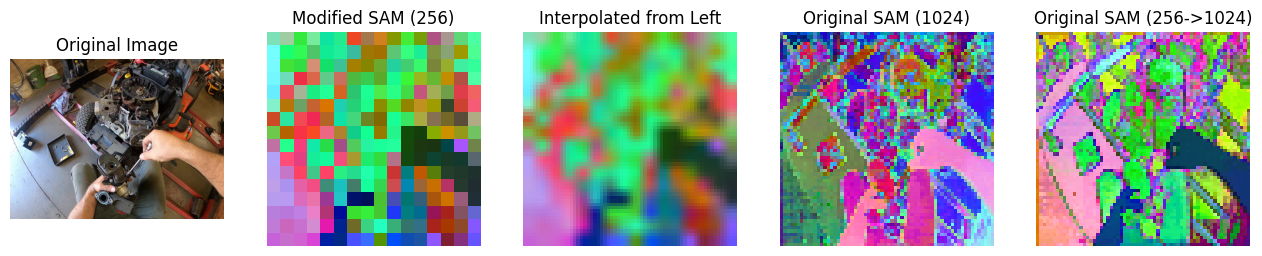

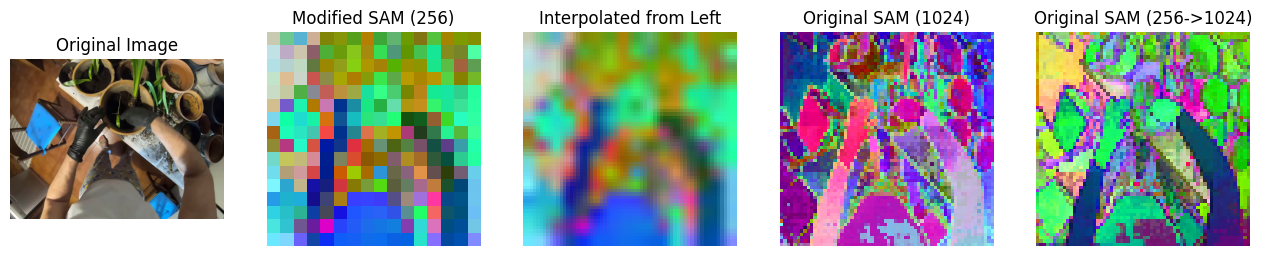

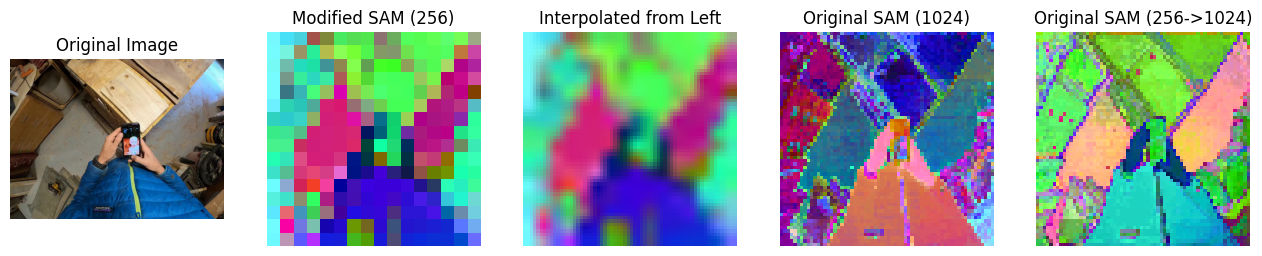

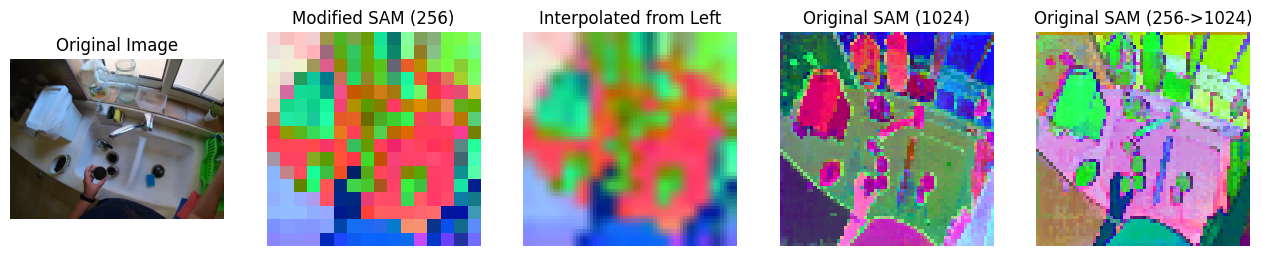

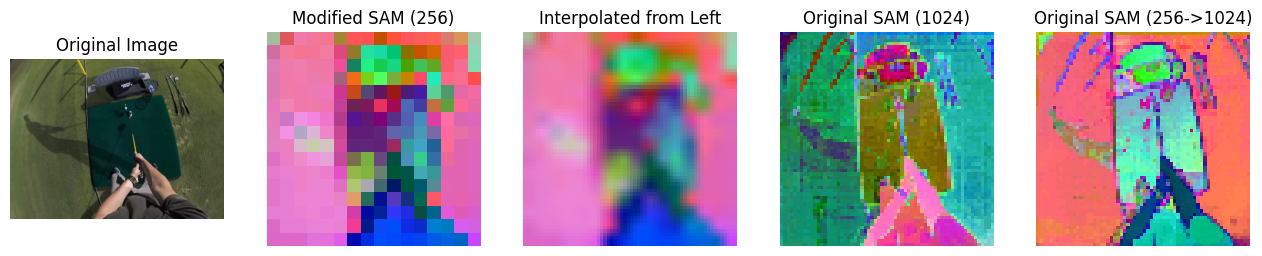

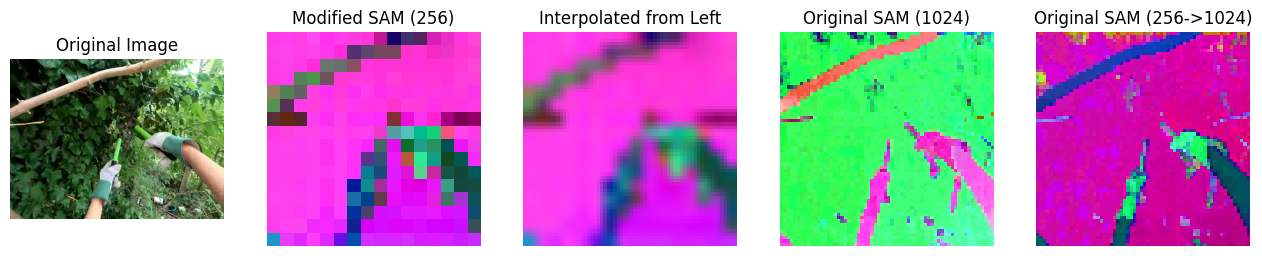

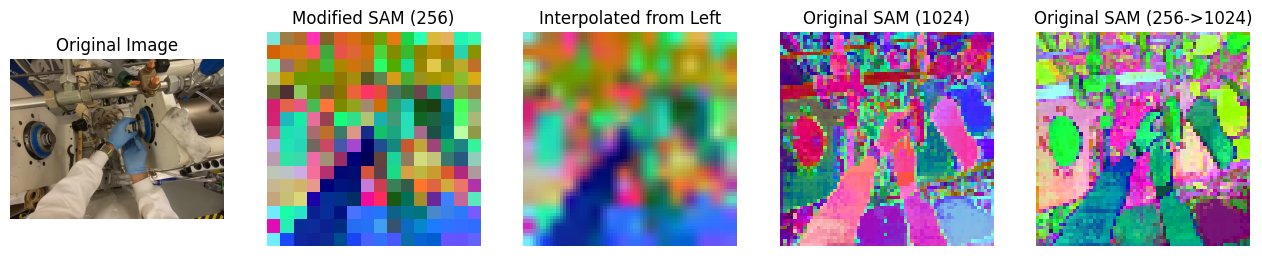

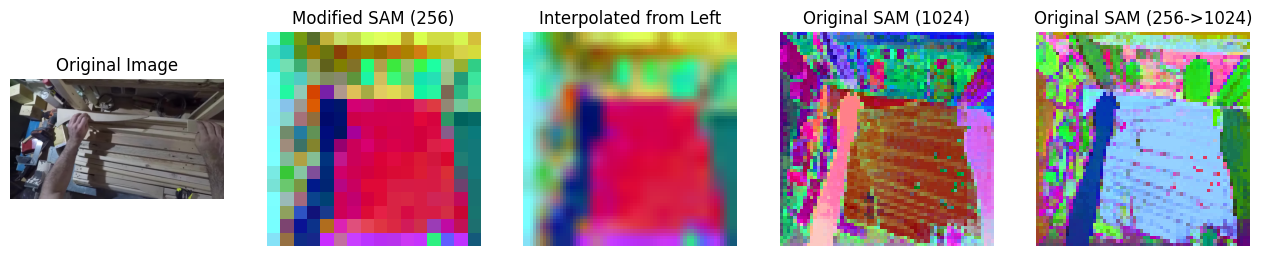

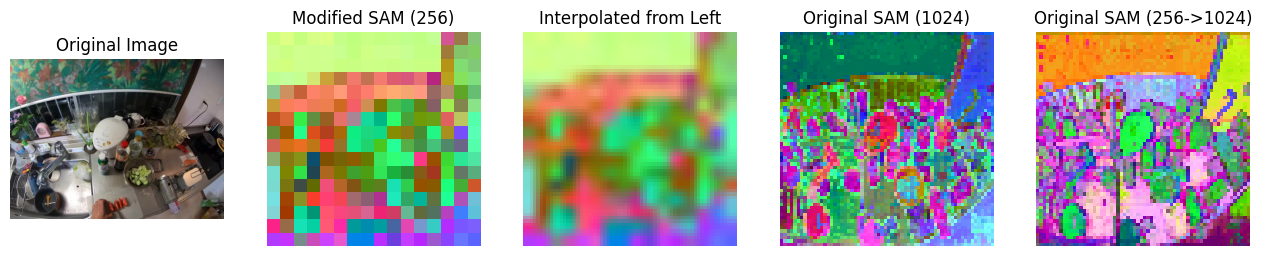

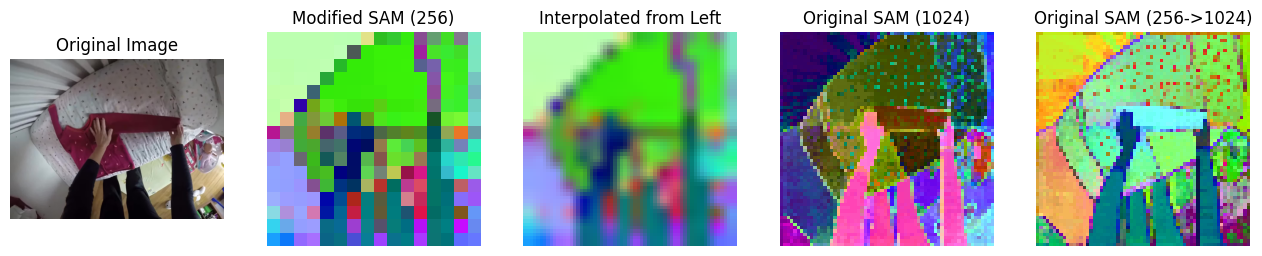

In [ ]:
from matplotlib import pyplot as plt

for idx in range(10):
    fig, axs = plt.subplots(1, 5, figsize=(16, 5))

    # Display images
    axs[0].imshow(images[idx])
    axs[0].set_title('Original Image')

    axs[1].imshow(tsne_rgb1[idx])
    axs[1].set_title(f'Modified SAM (256)')

    axs[2].imshow(tsne_rgb4[idx])
    axs[2].set_title('Interpolated from Left')

    axs[3].imshow(tsne_rgb2[idx])
    axs[3].set_title(f'Original SAM (1024)')

    axs[4].imshow(tsne_rgb3[idx])
    axs[4].set_title(f'Original SAM (256->1024)')

    # # Add a main title for the entire figure
    # fig.suptitle(f'Comparison of Clustering Results for Image {idx + 1}', fontsize=16, y=1.02)

    # # Add a summary below the figure
    # fig.text(0.5, -0.05,
    #          'This figure compares the original image, SAM outputs at different resolutions, '
    #          'and interpolated results for better visualization.',
    #          ha='center', fontsize=12)

    for ax in axs:
        ax.axis('off')

    # Adjust layout for better spacing
    # plt.tight_layout()
    plt.show()


## Full Finetuned

In [ ]:
def dict_to_namespace(d):
    return SimpleNamespace(**d)

config_dict = {
    "model_type": "vit_b",
    "checkpoint_path": "sam_vit_b_01ec64.pth",
    "freeze_image_encoder": False,
    "freeze_prompt_encoder": False,
    "freeze_mask_decoder": False,
    "batch_size": 4,
    'patch_size': 16,
    "steps": 133,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "metrics_interval": 20,
    "output_dir": 'project_checkpoints-v2/'
}

args = dict_to_namespace(config_dict)

finetuned_model = v2.SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=None,
    val_dataset=None,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    patch_size = 16,
)


checkpoint_path = "last_full.ckpt"
DEVICE = 'cuda'
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))

finetuned_model.load_state_dict(checkpoint["state_dict"])
finetuned_model.eval()
finetuned_model.to(DEVICE)

/content/drive/.shortcut-targets-by-id/1uetsGLzYUKFWfjNan9S9dahWTlFEDwPX/cis-680-team/cis680-team/Full_Segment_Anything/build_sam.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

SAMFinetuner(
  (model): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256, kernel_size=(3, 3), str

In [ ]:
# for 256 finetuned
ncut_model5 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=finetuned_model.model, img_size=256)
model_features5 = extract_features(images_tsf1, ncut_model5, node_type='attn', layer=layer, batch_size=batch_size)

inp5 = model_features5.reshape(-1, 768)
eigvectors5, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp5)
_, tsne_rgb5 = rgb_from_tsne_3d(eigvectors5, device='cuda:0')

eigvectors5 = eigvectors5.reshape(-1, 16, 16, 100) # (B, H, W, num_eig)
tsne_rgb5 = tsne_rgb5.reshape(-1, 16, 16, 3) # (B, H, W, 3)

# for 256 interpolated to 1024 for visual
tsne_rgb6 = tsne_rgb5.permute(0, 3, 1, 2)  # Now shape is [100, 3, 16, 16]
tsne_rgb6 = F.interpolate(tsne_rgb6, size=(64, 64), mode='bilinear', align_corners=False)
tsne_rgb6 = tsne_rgb6.permute(0, 2, 3, 1)  # Final shape is [100, 64, 64, 3]

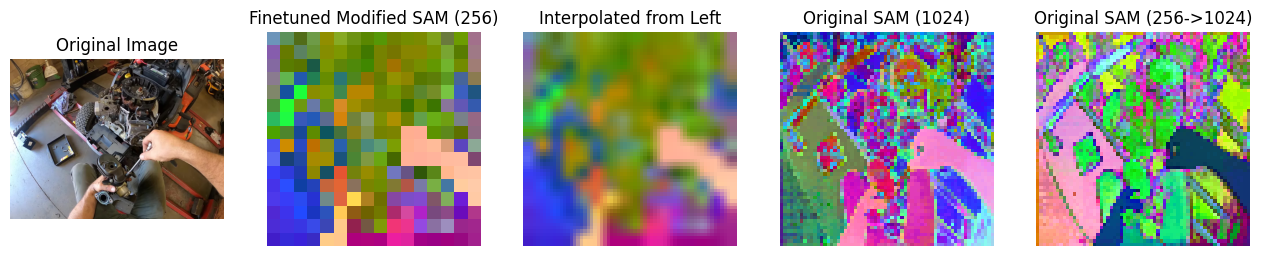

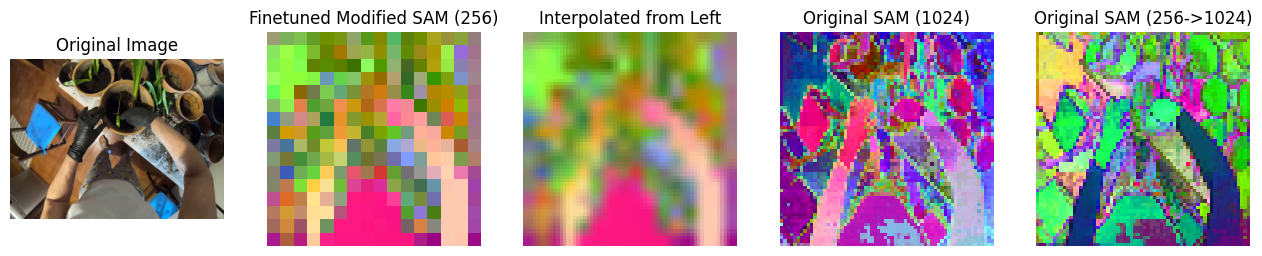

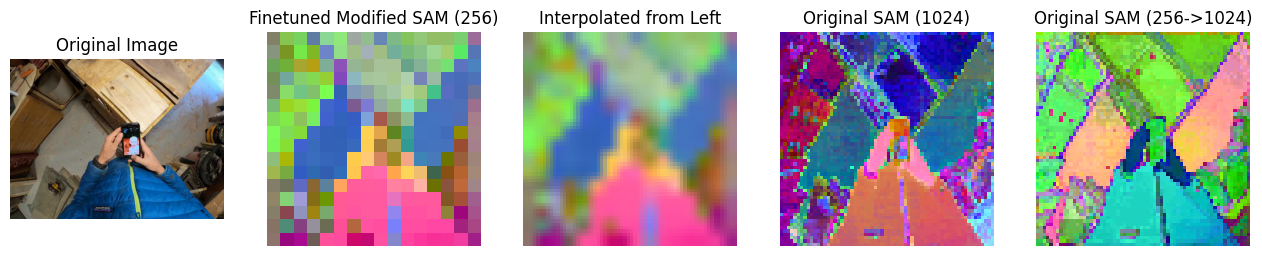

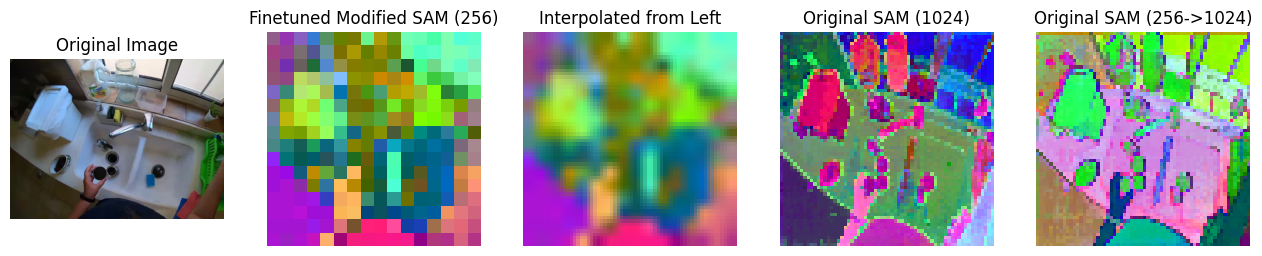

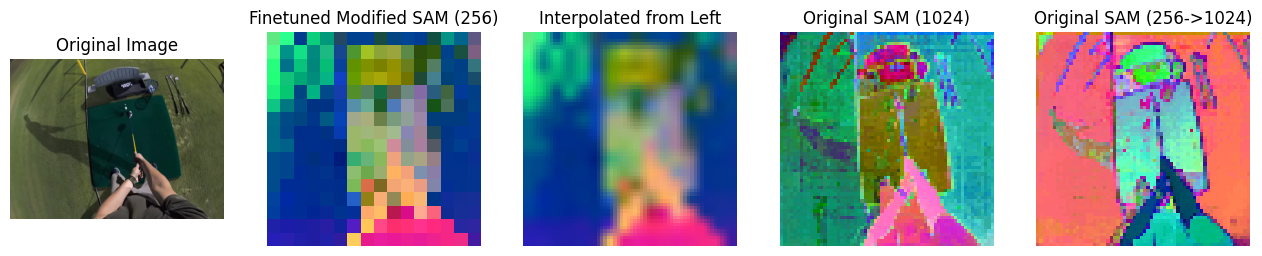

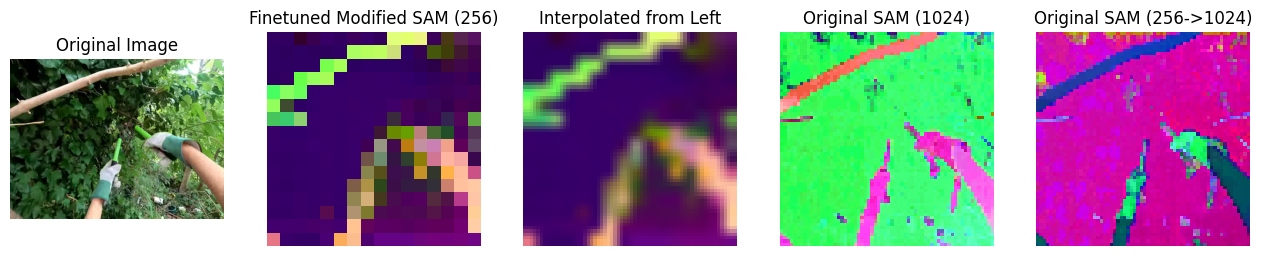

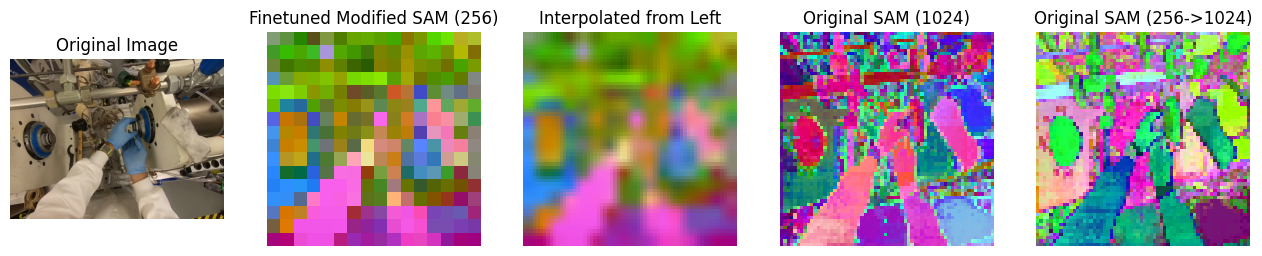

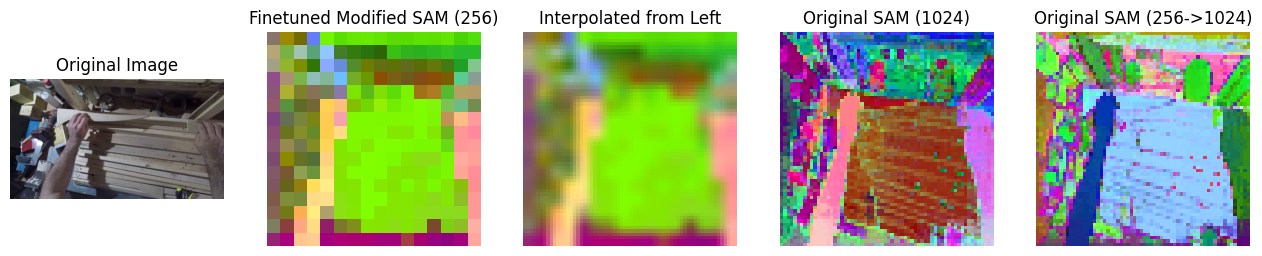

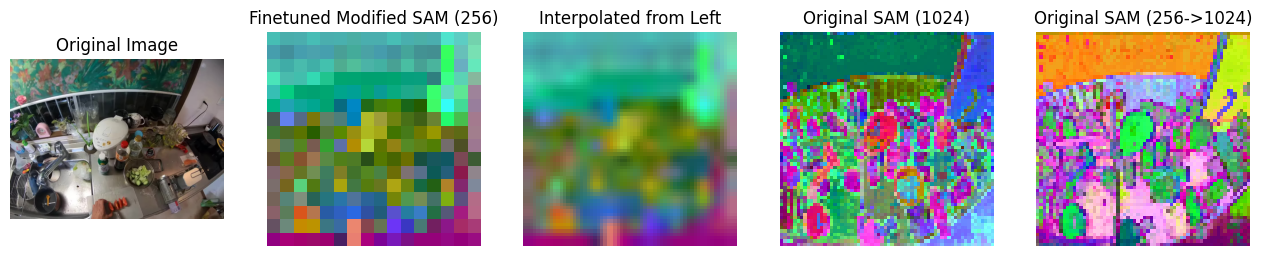

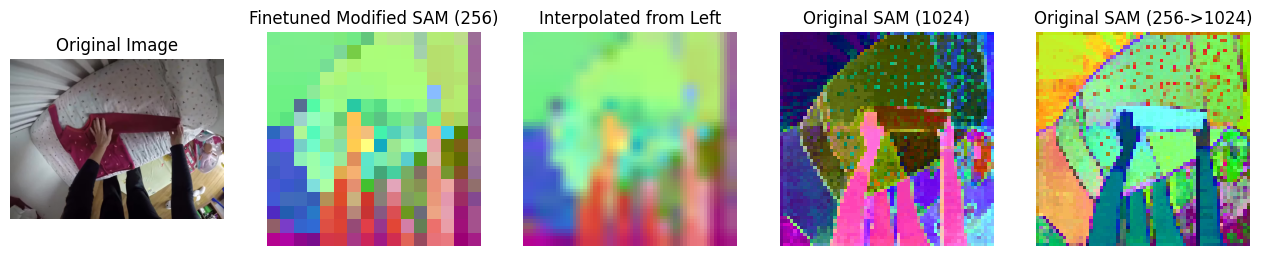

In [ ]:
from matplotlib import pyplot as plt

for idx in range(10):
    fig, axs = plt.subplots(1, 5, figsize=(16, 5))

    # Display images
    axs[0].imshow(images[idx])
    axs[0].set_title('Original Image')

    axs[1].imshow(tsne_rgb5[idx])
    axs[1].set_title(f'Finetuned Modified SAM (256)')

    axs[2].imshow(tsne_rgb6[idx])
    axs[2].set_title('Interpolated from Left')

    axs[3].imshow(tsne_rgb2[idx])
    axs[3].set_title(f'Original SAM (1024)')

    axs[4].imshow(tsne_rgb3[idx])
    axs[4].set_title(f'Original SAM (256->1024)')

    # # Add a main title for the entire figure
    # fig.suptitle(f'Comparison of Clustering Results for Image {idx + 1}', fontsize=16, y=1.02)

    # # Add a summary below the figure
    # fig.text(0.5, -0.05,
    #          'This figure compares the original image, SAM outputs at different resolutions, '
    #          'and interpolated results for better visualization.',
    #          ha='center', fontsize=12)

    for ax in axs:
        ax.axis('off')

    # Adjust layout for better spacing
    # plt.tight_layout()
    plt.show()


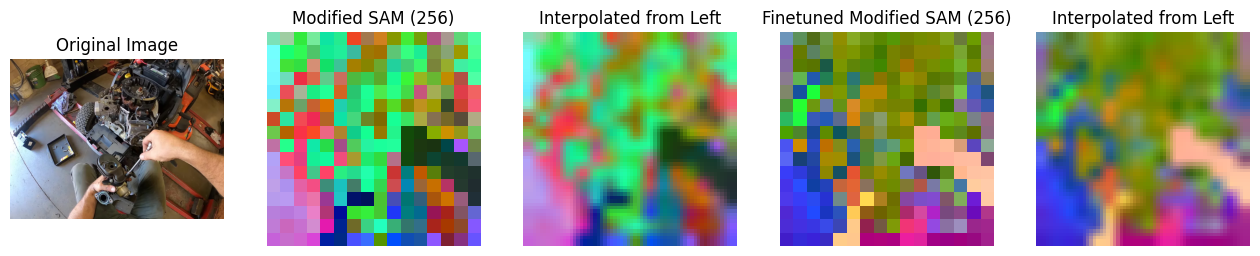

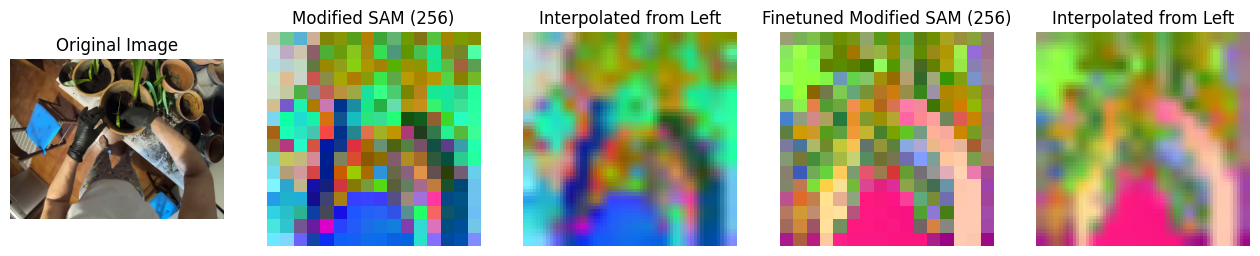

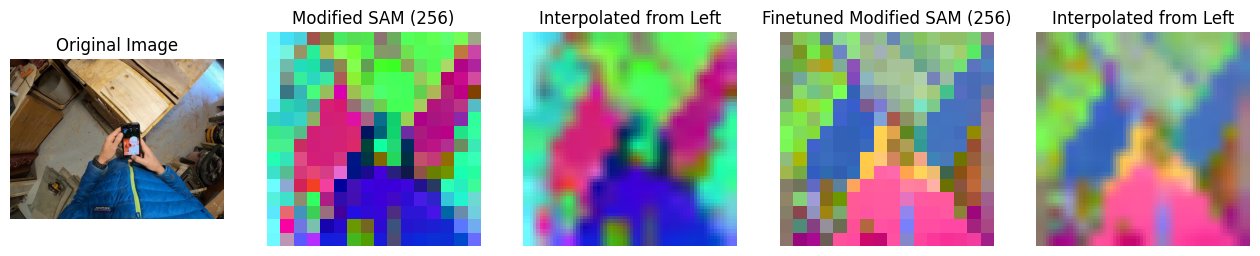

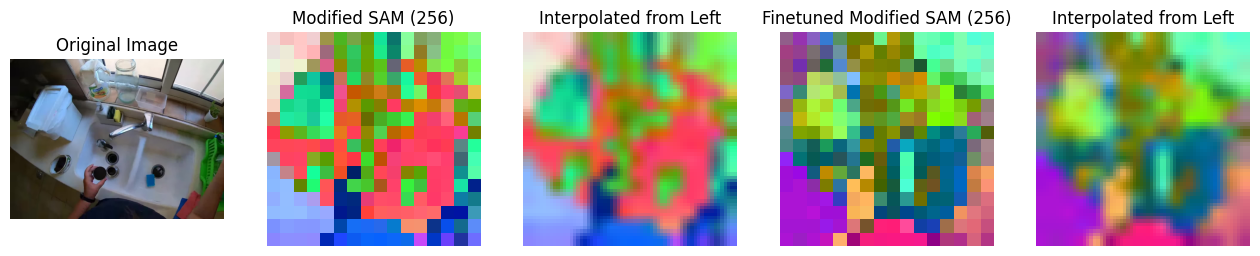

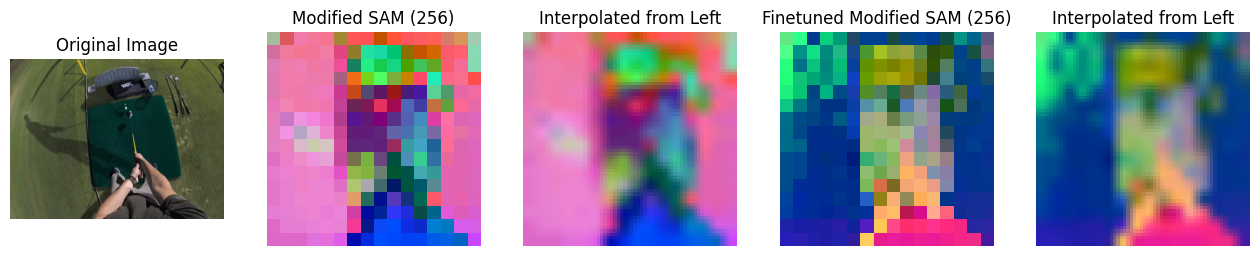

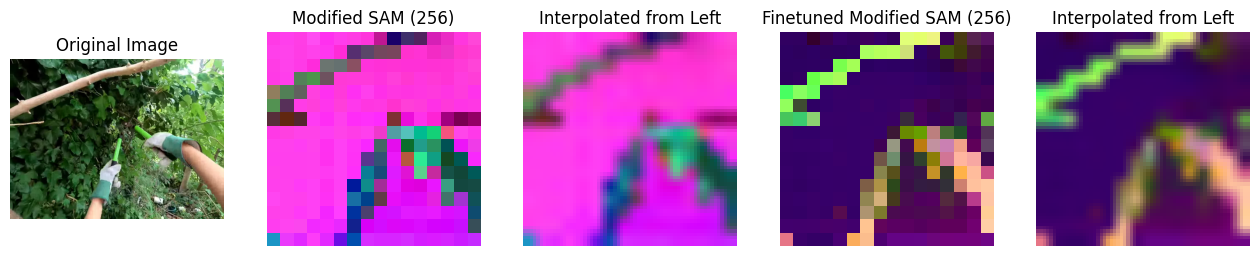

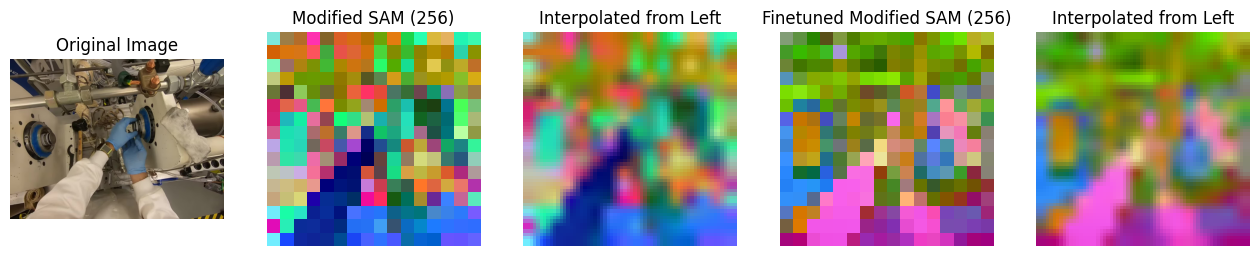

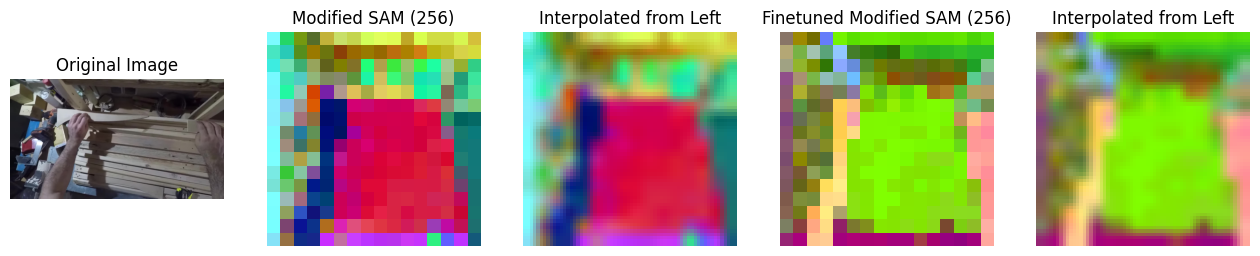

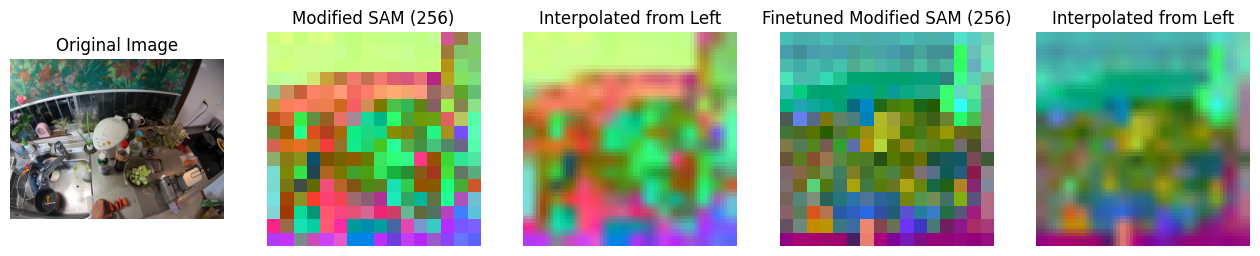

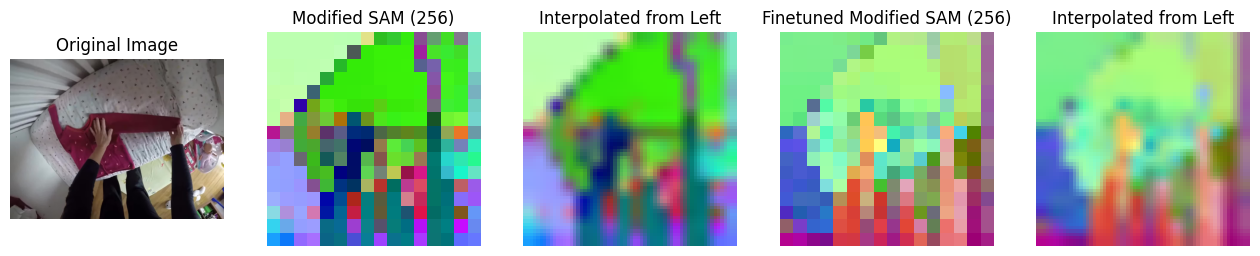

In [ ]:
from matplotlib import pyplot as plt

for idx in range(10):
    fig, axs = plt.subplots(1, 5, figsize=(16, 5))

    # Display images
    axs[0].imshow(images[idx])
    axs[0].set_title('Original Image')

    axs[1].imshow(tsne_rgb1[idx])
    axs[1].set_title(f'Modified SAM (256)')

    axs[2].imshow(tsne_rgb4[idx])
    axs[2].set_title('Interpolated from Left')

    axs[3].imshow(tsne_rgb5[idx])
    axs[3].set_title(f'Finetuned Modified SAM (256)')

    axs[4].imshow(tsne_rgb6[idx])
    axs[4].set_title('Interpolated from Left')

    for ax in axs:
        ax.axis('off')

    # Adjust layout for better spacing
    # plt.tight_layout()
    plt.show()

## LoRA finetuned

In [ ]:
def dict_to_namespace(d):
    return SimpleNamespace(**d)

config_dict = {
    "model_type": "vit_b",
    "checkpoint_path": "sam_vit_b_01ec64.pth",
    "freeze_image_encoder": False,
    "freeze_prompt_encoder": False,
    "freeze_mask_decoder": False,
    "batch_size": 4,
    'patch_size': 16,
    "steps": 133,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "metrics_interval": 20,
    "output_dir": None
}

args = dict_to_namespace(config_dict)

finetuned_lora = v3.SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=None,
    val_dataset=None,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    patch_size = 16,
)


checkpoint_path = "last_lora.ckpt"
DEVICE = 'cuda'
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

finetuned_lora.load_state_dict(checkpoint["state_dict"])
finetuned_lora.eval()
finetuned_lora.to(DEVICE)

<ipython-input-19-a099003f2653>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


SAMFinetuner(
  (model): LoRA_sam(
    (sam): Sam(
      (image_encoder): ImageEncoderViT(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (blocks): ModuleList(
          (0-11): 12 x Block(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): LoRA_qkv(
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (linear_a_q): Linear(in_features=768, out_features=512, bias=False)
                (linear_b_q): Linear(in_features=512, out_features=768, bias=False)
                (linear_a_v): Linear(in_features=768, out_features=512, bias=False)
                (linear_b_v): Linear(in_features=512, out_features=768, bias=False)
              )
              (proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  

In [ ]:
# for 256 finetuned LoRA
ncut_model7 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=finetuned_lora.model.sam, img_size=256)
model_features7 = extract_features(images_tsf1, ncut_model7, node_type='attn', layer=layer, batch_size=batch_size)

inp7 = model_features7.reshape(-1, 768)
eigvectors7, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp7)
_, tsne_rgb7 = rgb_from_tsne_3d(eigvectors7, device='cuda:0')

eigvectors7 = eigvectors7.reshape(-1, 16, 16, 100) # (B, H, W, num_eig)
tsne_rgb7 = tsne_rgb7.reshape(-1, 16, 16, 3) # (B, H, W, 3)

# for 256 interpolated to 1024 for visual
tsne_rgb8 = tsne_rgb7.permute(0, 3, 1, 2)  # Now shape is [100, 3, 16, 16]
tsne_rgb8 = F.interpolate(tsne_rgb8, size=(64, 64), mode='bilinear', align_corners=False)
tsne_rgb8 = tsne_rgb8.permute(0, 2, 3, 1)  # Final shape is [100, 64, 64, 3]

In [ ]:
from matplotlib import pyplot as plt

for idx in range(10):
    fig, axs = plt.subplots(1, 6, figsize=(16, 6))

    # Display images
    axs[0].imshow(images[idx])
    axs[0].set_title('Original Image')

    axs[1].imshow(tsne_rgb4[idx])
    axs[1].set_title(f'Modified SAM (256)')

    axs[2].imshow(tsne_rgb6[idx])
    axs[2].set_title(f'Finetuned (256)')

    axs[3].imshow(tsne_rgb8[idx])
    axs[3].set_title('LoRA Finetuned (256)')

    axs[4].imshow(tsne_rgb2[idx])
    axs[4].set_title(f'Original (1024)')

    axs[5].imshow(tsne_rgb3[idx])
    axs[5].set_title(f'Original (256->1024)')

    # # Add a main title for the entire figure
    # fig.suptitle(f'Comparison of Clustering Results for Image {idx + 1}', fontsize=16, y=1.02)

    # # Add a summary below the figure
    # fig.text(0.5, -0.05,
    #          'This figure compares the original image, SAM outputs at different resolutions, '
    #          'and interpolated results for better visualization.',
    #          ha='center', fontsize=12)

    for ax in axs:
        ax.axis('off')

    # Adjust layout for better spacing
    # plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Layer Insertion Comparison

In [ ]:
DEVICE = 'cuda'
# for 256
images_tsf1 = torch.stack([transform_image(img, resolution=(256, 256)) for img in images])
# for 1024
images_tsf2 = torch.stack([transform_image(img, resolution=(1024, 1024)) for img in images])
# for 1024 -> 256 -> 1024
images_tsf3 = torch.stack([resize_tensor(transform_image(img, resolution=(256, 256)), (1024, 1024)) for img in images])

# for 256
modified_sam = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth', custom_img_size=256).cuda()

# for 1024 and 1024 -> 256 -> 1024
original_sam = sa.sam_model_registry['vit_b'](checkpoint="sam_vit_b_01ec64.pth").cuda()
original_sam.eval()

def dict_to_namespace(d):
    return SimpleNamespace(**d)

config_dict = {
    "model_type": "vit_b",
    "checkpoint_path": "sam_vit_b_01ec64.pth",
    "freeze_image_encoder": False,
    "freeze_prompt_encoder": False,
    "freeze_mask_decoder": False,
    "batch_size": 4,
    'patch_size': 16,
    "steps": 133,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "metrics_interval": 20,
    "output_dir": None
}

args = dict_to_namespace(config_dict)
# full finetune
finetuned_model = v2.SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=None,
    val_dataset=None,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    patch_size = 16,
)

checkpoint_path = "last_full.ckpt"
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))

finetuned_model.load_state_dict(checkpoint["state_dict"])
finetuned_model.eval()
finetuned_model.to(DEVICE)

# lora
finetuned_lora = v3.SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=None,
    val_dataset=None,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    patch_size = 16,
)

checkpoint_path = "last_lora.ckpt"
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))

finetuned_lora.load_state_dict(checkpoint["state_dict"])
finetuned_lora.eval()
finetuned_lora.to(DEVICE)

# for 256
ncut_model1 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=modified_sam, img_size=256)

# for 1024
ncut_model2 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=original_sam, img_size=1024)

# for 256 finetuned
ncut_model5 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=finetuned_model.model, img_size=256)

# for 256 finetuned LoRA
ncut_model7 = ncut_pytorch.backbone.MODEL_DICT["SAM(sam_vit_b)"](project_special=finetuned_lora.model.sam, img_size=256)



/content/drive/.shortcut-targets-by-id/1uetsGLzYUKFWfjNan9S9dahWTlFEDwPX/cis-680-team/cis680-team/./Full_Segment_Anything/build_sam.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

In [ ]:
def visual_comparison(layer=11, batch=4, output_dir='layer_comparison'):

  # for 256
  model_features1 = extract_features(images_tsf1, ncut_model1, node_type='attn', layer=layer, batch_size=batch_size)
  # for 1024
  model_features2 = extract_features(images_tsf2, ncut_model2, node_type='attn', layer=layer, batch_size=batch_size)
  # for 1024 -> 256 -> 1024
  model_features3 = extract_features(images_tsf3, ncut_model2, node_type='attn', layer=layer, batch_size=batch_size)
  # for 256 finetuned
  model_features5 = extract_features(images_tsf1, ncut_model5, node_type='attn', layer=layer, batch_size=batch_size)
  # for 256 finetuned LoRA
  model_features7 = extract_features(images_tsf1, ncut_model7, node_type='attn', layer=layer, batch_size=batch_size)

  # for 256
  inp1 = model_features1.reshape(-1, 768)
  eigvectors1, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp1)
  _, tsne_rgb1 = rgb_from_tsne_3d(eigvectors1, device='cuda:0')
  # for 1024
  inp2 = model_features2.reshape(-1, 768)
  eigvectors2, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp2)
  _, tsne_rgb2 = rgb_from_tsne_3d(eigvectors2, device='cuda:0')
  # for 1024 -> 256 -> 1024
  inp3 = model_features3.reshape(-1, 768)
  eigvectors3, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp3)
  _, tsne_rgb3 = rgb_from_tsne_3d(eigvectors3, device='cuda:0')
  # for 256 finetuned
  inp5 = model_features5.reshape(-1, 768)
  eigvectors5, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp5)
  _, tsne_rgb5 = rgb_from_tsne_3d(eigvectors5, device='cuda:0')
  # for 256 finetuned LoRA
  inp7 = model_features7.reshape(-1, 768)
  eigvectors7, _ = NCUT(num_eig=100, device='cuda:0').fit_transform(inp7)
  _, tsne_rgb7 = rgb_from_tsne_3d(eigvectors7, device='cuda:0')

  # for 256
  eigvectors1 = eigvectors1.reshape(-1, 16, 16, 100) # (B, H, W, num_eig)
  tsne_rgb1 = tsne_rgb1.reshape(-1, 16, 16, 3) # (B, H, W, 3)

  # for 256 interpolated to 1024 for visual
  tsne_rgb4 = tsne_rgb1.permute(0, 3, 1, 2)  # Now shape is [100, 3, 16, 16]
  tsne_rgb4 = F.interpolate(tsne_rgb4, size=(64, 64), mode='bilinear', align_corners=False)
  tsne_rgb4 = tsne_rgb4.permute(0, 2, 3, 1)  # Final shape is [100, 64, 64, 3]

  # for 1024
  eigvectors2 = eigvectors2.reshape(-1, 64, 64, 100) # (B, H, W, num_eig)
  tsne_rgb2 = tsne_rgb2.reshape(-1, 64, 64, 3) # (B, H, W, 3)

  # for 1024 -> 256 -> 1024
  eigvectors3 = eigvectors3.reshape(-1, 64, 64, 100) # (B, H, W, num_eig)
  tsne_rgb3 = tsne_rgb3.reshape(-1, 64, 64, 3) # (B, H, W, 3)

  # for 256 finetuned
  eigvectors5 = eigvectors5.reshape(-1, 16, 16, 100) # (B, H, W, num_eig)
  tsne_rgb5 = tsne_rgb5.reshape(-1, 16, 16, 3) # (B, H, W, 3)
  # for 256 interpolated to 1024 for visual
  tsne_rgb6 = tsne_rgb5.permute(0, 3, 1, 2)  # Now shape is [100, 3, 16, 16]
  tsne_rgb6 = F.interpolate(tsne_rgb6, size=(64, 64), mode='bilinear', align_corners=False)
  tsne_rgb6 = tsne_rgb6.permute(0, 2, 3, 1)  # Final shape is [100, 64, 64, 3]

  # for 256 finetuned LoRA
  eigvectors7 = eigvectors7.reshape(-1, 16, 16, 100) # (B, H, W, num_eig)
  tsne_rgb7 = tsne_rgb7.reshape(-1, 16, 16, 3) # (B, H, W, 3)

  # for 256 interpolated to 1024 for visual
  tsne_rgb8 = tsne_rgb7.permute(0, 3, 1, 2)  # Now shape is [100, 3, 16, 16]
  tsne_rgb8 = F.interpolate(tsne_rgb8, size=(64, 64), mode='bilinear', align_corners=False)
  tsne_rgb8 = tsne_rgb8.permute(0, 2, 3, 1)  # Final shape is [100, 64, 64, 3]

  from matplotlib import pyplot as plt
  import os
  os.makedirs(output_dir, exist_ok=True)
  for idx in range(10):
      fig, axs = plt.subplots(1, 6, figsize=(16, 6))

      # Display images
      axs[0].imshow(images[idx])
      axs[0].set_title('Original Image')

      axs[1].imshow(tsne_rgb4[idx])
      axs[1].set_title(f'Modified SAM (256)')

      axs[2].imshow(tsne_rgb6[idx])
      axs[2].set_title(f'Finetuned (256)')

      axs[3].imshow(tsne_rgb8[idx])
      axs[3].set_title('LoRA Finetuned (256)')

      axs[4].imshow(tsne_rgb2[idx])
      axs[4].set_title(f'Original (1024)')

      axs[5].imshow(tsne_rgb3[idx])
      axs[5].set_title(f'Original (256->1024)')

      # # Add a main title for the entire figure
      # fig.suptitle(f'Comparison of Clustering Results for Image {idx + 1}', fontsize=16, y=1.02)

      # # Add a summary below the figure
      # fig.text(0.5, -0.05,
      #          'This figure compares the original image, SAM outputs at different resolutions, '
      #          'and interpolated results for better visualization.',
      #          ha='center', fontsize=12)

      for ax in axs:
          ax.axis('off')

      # Adjust layout for better spacing
      # plt.tight_layout()
      filename = os.path.join(output_dir, f'comparison_layer{layer}_{idx:02d}.png')

      # Save the figure as a PNG file (lossless)
      fig.savefig(filename, format='png', dpi=300, bbox_inches='tight')
      plt.show()



In [ ]:
for i in range(12):
  visual_comparison(layer=i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
visual_comparison(layer=1)

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --to PDF "ncut.ipynb"

[NbConvertApp] Converting notebook ncut.ipynb to PDF
[NbConvertApp] Support files will be in ncut_files/
[NbConvertApp] Making directory ./ncut_files
[NbConvertApp] Writing 63197 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 3634310 bytes to ncut.pdf
